In [20]:
#this notebook uses the entire dataset (that is not included in this release, see repo README)
#we provide it to show how the results/figures/tables of the paper are generated

import numpy as np
import pandas as pd
name = "ds806" #change it to your name
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
import glob
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from utils import *
import time
import os

from sklearn.linear_model import LogisticRegression,  LinearRegression, Ridge,ElasticNet, Lasso, SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib

from keras.layers import Input, Dense, Dropout,BatchNormalization
from keras.models import Model, load_model,model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
frame = pd.read_csv("data/extracted_features_all_users_with_MVPA_noncal_July2020.csv", index_col=0)
frame.head()

,25%_ACC,25%_ENMO,25%_MET_LPA,25%_MET_MVPA,25%_MET_VigPA,25%_MET_sed,25%_MVPA_noncal,25%_Sed_noncal,25%_VPA_noncal,25%_hrv_milliseconds,25%_mean_hr,50%_ACC,50%_ENMO,50%_MET_LPA,50%_MET_MVPA,50%_MET_VigPA,50%_MET_sed,50%_MVPA_noncal,50%_Sed_noncal,50%_VPA_noncal,50%_hrv_milliseconds,50%_mean_hr,75%_ACC,75%_ENMO,75%_MET_LPA,75%_MET_MVPA,75%_MET_VigPA,75%_MET_sed,75%_MVPA_noncal,75%_Sed_noncal,75%_VPA_noncal,75%_hrv_milliseconds,75%_mean_hr,RHR,age,bmi,count_ACC,count_ENMO,count_MET_LPA,count_MET_MVPA,count_MET_VigPA,count_MET_sed,count_MVPA_noncal,count_Sed_noncal,count_VPA_noncal,count_hrv_milliseconds,count_mean_hr,height,id,max_ACC,max_ENMO,max_MET_LPA,max_MET_MVPA,max_MET_VigPA,max_MET_sed,max_MVPA_noncal,max_Sed_noncal,max_VPA_noncal,max_hrv_milliseconds,max_mean_hr,mean_ACC,mean_ENMO,mean_MET_LPA,mean_MET_MVPA,mean_MET_VigPA,mean_MET_sed,mean_MVPA_noncal,mean_Sed_noncal,mean_VPA_noncal,mean_hrv_milliseconds,mean_mean_hr,min_ACC,min_ENMO,min_MET_LPA,min_MET_MVPA,min_MET_VigPA,min_MET_sed,min_MVPA_noncal,min_Sed_noncal,min_VPA_noncal,min_hrv_milliseconds,min_mean_hr,month,month_cos_time,month_sin_time,mvpa_daily_count,mvpa_daily_count_noncal,real_time,sed_daily_count,sed_daily_count_noncal,sex,slope_ACC,slope_ENMO,slope_MET_LPA,slope_MET_MVPA,slope_MET_VigPA,slope_MET_sed,slope_MVPA_noncal,slope_Sed_noncal,slope_VPA_noncal,slope_hrv_milliseconds,slope_mean_hr,std_ACC,std_ENMO,std_MET_LPA,std_MET_MVPA,std_MET_VigPA,std_MET_sed,std_MVPA_noncal,std_Sed_noncal,std_VPA_noncal,std_hrv_milliseconds,std_mean_hr,vpa_daily_count,vpa_daily_count_noncal,weight
0,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,66.375999,0.015,2.543696,0.0,0.0,0.0,0.0,0.0,0.009,0.0,157.0,77.554001,0.234,38.849461,0.000000,0.000000,0.0,0.000000,0.0,0.216,0.0,211.0,89.494501,62.666730,46.0,28.563646,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,1.839,608551N,3.297,546.632812,5.958082,5.958082,5.958082,0.499869,3.297,0.975,0.000,1555.0,136.427002,0.157728,26.205971,0.503840,0.307573,0.000721,0.026814,0.030209,0.127520,0.000000,175.058519,78.724571,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-180.0,52.365002,3.0,6.123234e-17,1.000000,168.833333,26.166667,2011-03-17 12:38:00,1179.714286,1179.714286,1.0,-0.000008,-0.001269,-0.000055,-0.000047,-2.005316e-07,1.034424e-07,-0.000004,-3.796540e-06,0.000000e+00,0.005148,-0.001517,0.289485,47.991135,0.940380,0.836552,0.065565,0.068968,0.231807,0.194346,0.000000,93.889429,14.898837,1.000000,0.000000,96.6
1,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,72.498001,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,203.0,79.259003,0.036,6.025071,0.000000,0.000000,0.0,0.018802,0.0,0.033,0.0,563.0,86.390999,68.391240,47.0,23.403175,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,1.743,705051H,2.997,496.898895,4.474391,4.474391,0.000000,0.497736,2.997,0.975,0.000,1821.0,127.177002,0.063776,10.629453,0.146806,0.066505,0.000000,0.044098,0.019868,0.043908,0.000000,371.541575,79.729309,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1547.0,58.625999,1.0,8.660254e-01,0.500000,32.125000,18.000000,2010-01-23 18:45:00,1177.625000,1177.625000,0.0,-0.000003,-0.000547,0.000010,-0.000002,0.000000e+00,-1.020129e-08,-0.000004,8.523049e-07,0.000000e+00,0.007257,0.000887,0.203587,33.752403,0.531500,0.403107,0.000000,0.089634,0.177140,0.108699,0.000000,350.484761,10.069210,0.000000,0.000000,71.1
2,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,57.288500,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,70.0,65.306499,0.144,23.929281,0.000000,0.000000,0.0,0.000000,0.0,0.048,0.0,109.0,72.082998,55.442856,49.0,27.513542,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,1.740,612538F,7.608,1261.309326,8.154249,8.154249,8.154249,0.497530,7.608,0.984,7.608,1703.0,137.863998,0.276521,45.900051,0.603344,0.460276,0.022634,0.034609,0.201595,0.074926,0.006138,105.800578,65.706253,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1281.0,45.201000,7.0,-8.660254e-01,-0.500000,184.571429,109.428571,2013-07-25 12:40:00

In [3]:
frame.shape

(12158, 116)

### Introduce the VO2max label

#### Fenland I

In [4]:
#Fenland 1 
fitness_df = pd.read_csv("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/PHFENLANDR90002152019_26Nov2019/PHFENLANDR90002152019B_Prerelease_08Apr2020.csv")
fitness_df.index = fitness_df['serno'] #move the user_id to index
del fitness_df['serno']
fitness_df = fitness_df[['P_TR_FITNESS_HighPt_est']] #standartize column names with FII
fitness_df.rename(columns={'P_TR_FITNESS_HighPt_est': 'TR_FITNESS_HighPt_est'}, inplace=True)
fitness_df.shape

(12435, 1)

In [5]:
#merge Fenland 1 with sensors and remove missing fitness entries
frame_with_fitness =  pd.merge(frame, fitness_df, left_on='id', right_on='serno').dropna(how='any') 
frame_with_fitness.shape

(11059, 117)

In [6]:
#remove timestamp, count_ features and index (somehow the feature extraction created an index column)
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('real_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('count_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('index')]

#remove treadmill informed MVPA variables
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.contains('_MET_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.endswith('daily_count')]

frame_with_fitness.shape

(11059, 70)

#### Fenland II

In [7]:
#Fenland 2 repeats
fitness_df_2 = pd.read_stata("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/Fen2_Summary_fitness_vars_Apr_2020/Fen2_summary_fitness_vars_IP_8Apr2020.dta")
fitness_df_2['id'] = fitness_df_2.id[:-2].astype(str).str[:-2]
fitness_df_2["bmi"] = fitness_df_2["weight"] / (fitness_df_2["height"] * fitness_df_2["height"])
fitness_df_2 = fitness_df_2[['id','age', 'bmi', 'height', 'weight','TR_FITNESS_HighPt_est']] 
fitness_df_2.shape

(3041, 6)

In [8]:
#we merge the repeats with FI and generate two ID groups so that we can select train/test sets later
#we reset the index because it was creating issues in disjoint splits later
repeats = pd.merge(frame_with_fitness, fitness_df_2, on='id', suffixes = ("_f1","_repeats")).dropna(how='any').reset_index(drop=True)
IDs_repeats = frame_with_fitness[frame_with_fitness['id'].isin(repeats.id)].id
IDs_controls = frame_with_fitness[~frame_with_fitness['id'].isin(repeats.id)].id
print (repeats.shape,IDs_repeats.shape, IDs_controls.shape)

(2675, 75) (2675,) (8384,)


### Create new outcome (delta of present - future)

In [9]:
repeats["fitness_delta"] = repeats.TR_FITNESS_HighPt_est_f1-repeats.TR_FITNESS_HighPt_est_repeats

In [11]:
repeats.head()

,25%_ACC,25%_ENMO,25%_MVPA_noncal,25%_Sed_noncal,25%_VPA_noncal,25%_hrv_milliseconds,25%_mean_hr,50%_ACC,50%_ENMO,50%_MVPA_noncal,50%_Sed_noncal,50%_VPA_noncal,50%_hrv_milliseconds,50%_mean_hr,75%_ACC,75%_ENMO,75%_MVPA_noncal,75%_Sed_noncal,75%_VPA_noncal,75%_hrv_milliseconds,75%_mean_hr,RHR,age_f1,bmi_f1,height_f1,id,max_ACC,max_ENMO,max_MVPA_noncal,max_Sed_noncal,max_VPA_noncal,max_hrv_milliseconds,max_mean_hr,mean_ACC,mean_ENMO,mean_MVPA_noncal,mean_Sed_noncal,mean_VPA_noncal,mean_hrv_milliseconds,mean_mean_hr,min_ACC,min_ENMO,min_MVPA_noncal,min_Sed_noncal,min_VPA_noncal,min_hrv_milliseconds,min_mean_hr,month,month_cos_time,month_sin_time,mvpa_daily_count_noncal,sed_daily_count_noncal,sex,slope_ACC,slope_ENMO,slope_MVPA_noncal,slope_Sed_noncal,slope_VPA_noncal,slope_hrv_milliseconds,slope_mean_hr,std_ACC,std_ENMO,std_MVPA_noncal,std_Sed_noncal,std_VPA_noncal,std_hrv_milliseconds,std_mean_hr,vpa_daily_count_noncal,weight_f1,TR_FITNESS_HighPt_est_f1,age_repeats,bmi_repeats,height_repeats,weight_repeats,TR_FITNESS_HighPt_est_repeats,fitness_delta
0,0.0,0.057,0.0,0.0,0.0,125.0,72.498001,0.000,0.057000,0.0,0.0,0.0,203.0,79.259003,0.036,6.025071,0.0,0.033,0.0,563.00,86.390999,68.391240,47.0,23.403175,1.743,705051H,2.997,496.898895,2.997,0.975,0.000,1821.0,127.177002,0.063776,10.629453,0.019868,0.043908,0.000000,371.541575,79.729309,0.0,0.057,0.0,0.0,0.0,-1547.0,58.625999,1.0,8.660254e-01,0.500000,18.000000,1177.625000,0.0,-0.000003,-0.000547,-4.148881e-06,8.523049e-07,0.000000e+00,0.007257,0.000887,0.203587,33.752403,0.177140,0.108699,0.000000,350.484761,10.069210,0.000000,71.1,39.546337,53,24.045448,1.74,72.800003,40.711899,-1.165562
1,0.0,0.057,0.0,0.0,0.0,117.0,60.535500,0.000,0.057000,0.0,0.0,0.0,157.0,68.073997,0.024,4.035714,0.0,0.012,0.0,227.00,78.149998,49.900693,47.0,21.738970,1.845,708547Y,8.385,1390.120239,8.385,0.975,8.385,1211.0,170.033997,0.187419,31.129454,0.145473,0.041946,0.106676,181.723229,72.079414,0.0,0.057,0.0,0.0,0.0,8.0,47.161999,7.0,-8.660254e-01,-0.500000,31.285714,1230.142857,1.0,-0.000023,-0.003735,-1.669730e-05,-5.832935e-06,-1.518579e-05,-0.003955,-0.000654,0.969404,160.697083,0.968256,0.120041,0.938301,99.849187,17.780220,18.333333,74.0,49.077190,52,22.694019,1.83,76.000000,50.369160,-1.291970
2,0.0,0.057,0.0,0.0,0.0,164.0,63.606501,0.000,0.057000,0.0,0.0,0.0,227.0,71.217003,0.147,24.426622,0.0,0.102,0.0,383.00,82.558998,62.310473,51.0,32.016140,1.510,709372B,6.933,1149.407959,6.933,0.984,6.933,1696.0,152.925995,0.185559,30.820534,0.095941,0.089619,0.025493,298.080640,74.265182,0.0,0.057,0.0,0.0,0.0,-1258.0,48.339001,8.0,-5.000000e-01,-0.866025,47.428571,1295.857143,0.0,0.000007,0.001180,6.741181e-07,6.445138e-06,1.042777e-06,0.001569,0.000350,0.544475,90.263649,0.532577,0.173252,0.360157,195.433620,13.900171,7.666667,73.0,39.986778,56,31.095129,1.51,70.900002,41.704163,-1.717385
3,0.0,0.057,0.0,0.0,0.0,156.0,61.440499,0.003,0.554339,0.0,0.0,0.0,242.0,69.269501,0.249,41.336155,0.0,0.159,0.0,529.25,80.855751,61.228303,38.0,29.475311,1.800,601441F,5.631,933.562744,5.631,0.993,5.631,1805.0,144.376999,0.203498,33.794220,0.081565,0.121933,0.001615,357.376691,72.426178,0.0,0.057,0.0,0.0,0.0,0.0,50.797001,3.0,6.123234e-17,1.000000,70.142857,1291.142857,1.0,-0.000009,-0.001487,-6.159847e-06,-2.810371e-06,2.104395e-07,-0.003223,-0.000591,0.398155,66.008492,0.361206,0.218999,0.089177,280.835536,13.602605,0.600000,95.5,45.209652,46,27.098768,1.80,87.800003,41.931660,3.277992
4,0.0,0.057,0.0,0.0,0.0,211.0,59.757000,0.003,0.554339,0.0,0.0,0.0,485.0,71.013000,0.132,21.939926,0.0,0.093,0.0,617.00,82.154999,60.527966,42.0,19.423489,1.672,703097M,3.531,585.425293,3.531,0.981,0.000,1742.0,169.462997,0.141498,23.515217,0.047584,0.093914,0.000000,448.106359,73.137871,0.0,0.057,0.0,0.0,0.0,0.0,47.301998,11.0,8.660254e-01,-0.500000,38.714286,1250.428571,0.0,-0.000008,-0.001385,-5.792083e-06,-2.564225e-06,0.000000e+00,-0.013617,-0.000757,0.320900,53.198349,0.278236,0.185746,0.000000,239.606562,17.091295,0.000000,54.3,39.

### Split to disjoint train/test sets

In [12]:
#split in two disjoint groups of users
#https://stackoverflow.com/questions/44007496/random-sampling-with-pandas-data-frame-disjoint-groups

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=143)

idx1, idx2 = next(gss.split(repeats, groups=repeats.id))
print(idx1.shape, idx2.shape)

#multitas
# Get the split.                                           #this iloc :-1 changed to :-2 bc we have two outcomes now (delta)
#X_train, y_train_1, y_train_2 = repeats.iloc[idx1,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2],repeats.loc[idx1,'TR_FITNESS_HighPt_est_f1'], repeats.loc[idx1,'TR_FITNESS_HighPt_est_repeats']  
#X_test, y_test_1, y_test_2  = repeats.iloc[idx2,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2], repeats.loc[idx2,'TR_FITNESS_HighPt_est_f1'],  repeats.loc[idx2,'TR_FITNESS_HighPt_est_repeats']
   
# Get the split.                                           #this iloc :-1 changed to :-2 bc we have two outcomes now (delta)
X_train, y_train,  = repeats.iloc[idx1,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2],repeats.loc[idx1,'fitness_delta'],
X_test, y_test,   = repeats.iloc[idx2,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2], repeats.loc[idx2,'fitness_delta'],    
#make sure test users do not appear in train set
mask = np.isin(X_test.id, X_train.id)
assert mask.all() == False

IDs = np.concatenate((X_train.id, X_test.id)) #to be used in embedding user lookup later

#drop the userID (string hence keep only numeric data)
X_train = X_train._get_numeric_data()
X_test = X_test._get_numeric_data()

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2140,) (535,)
(2140, 68) (535, 68) (2140,) (535,)


In [13]:
X_train.columns

Index(['25%_ACC', '25%_ENMO', '25%_MVPA_noncal', '25%_Sed_noncal',
       '25%_VPA_noncal', '25%_hrv_milliseconds', '25%_mean_hr', '50%_ACC',
       '50%_ENMO', '50%_MVPA_noncal', '50%_Sed_noncal', '50%_VPA_noncal',
       '50%_hrv_milliseconds', '50%_mean_hr', '75%_ACC', '75%_ENMO',
       '75%_MVPA_noncal', '75%_Sed_noncal', '75%_VPA_noncal',
       '75%_hrv_milliseconds', '75%_mean_hr', 'RHR', 'age_f1', 'bmi_f1',
       'height_f1', 'max_ACC', 'max_ENMO', 'max_MVPA_noncal', 'max_Sed_noncal',
       'max_VPA_noncal', 'max_hrv_milliseconds', 'max_mean_hr', 'mean_ACC',
       'mean_ENMO', 'mean_MVPA_noncal', 'mean_Sed_noncal', 'mean_VPA_noncal',
       'mean_hrv_milliseconds', 'mean_mean_hr', 'min_ACC', 'min_ENMO',
       'min_MVPA_noncal', 'min_Sed_noncal', 'min_VPA_noncal',
       'min_hrv_milliseconds', 'min_mean_hr', 'month', 'month_cos_time',
       'month_sin_time', 'mvpa_daily_count_noncal', 'sed_daily_count_noncal',
       'sex', 'slope_ACC', 'slope_ENMO', 'slope_MVPA_noncal',


In [14]:
#flag to train only with anthro/metadata
antrhopometrics = False

In [15]:
if antrhopometrics==True:
    X_train = X_train[[ 'height_f1', 'weight_f1', 'sex', 'age_f1', 'bmi_f1','RHR']] #'RHR'
    X_test = X_test[[ 'height_f1', 'weight_f1', 'sex', 'age_f1', 'bmi_f1','RHR']] #'RHR'
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)    

(2140, 68) (535, 68) (2140,) (535,)


### Normalize and denoise (PCA)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
scaler_name = "data/scaler_FI.save"
scaler = joblib.load(scaler_name)

#scaler = StandardScaler()
X_train = scaler.transform(X_train) #X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
pca_flag = True
if pca_flag==True:
    scaler_pca = "data/PCA_FI_mapping_09999.save"
    pca_mapping = joblib.load(scaler_pca)
    #pca_explained = 0.9999
    pca = pca_mapping
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    print ("Explained variance:", pca.explained_variance_ratio_.cumsum()) 
    plt.plot(pca.explained_variance_ratio_.cumsum())

Explained variance: [0.19198117 0.31598844 0.40743699 0.48652977 0.55559902 0.61339824
 0.6527179  0.68484599 0.71507354 0.74295512 0.76729297 0.78747861
 0.80581373 0.82315224 0.83976298 0.85593665 0.87179033 0.88657134
 0.90045146 0.91382236 0.92611413 0.93540032 0.94358754 0.95082055
 0.95712849 0.96285126 0.96839968 0.97358831 0.97837773 0.98230121
 0.98575082 0.98878    0.99128152 0.99299078 0.9944609  0.99582106
 0.99700933 0.99768711 0.99830756 0.99888574 0.99924818 0.99946226
 0.99966094 0.99980443 0.999873   0.99993376]


In [18]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)    

(2140, 46) (535, 46) (2140,) (535,)


### Check that the two splits have similar VO2max ranges

<AxesSubplot:>

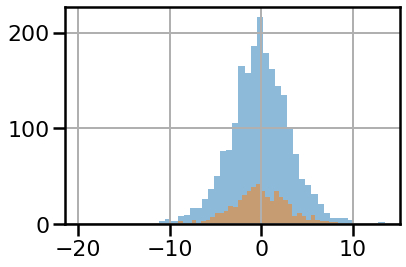

In [21]:
y_train.hist(bins=50, alpha=0.5)
y_test.hist(bins=50, alpha=0.5)

### Train model

In [22]:
training_mode = 'linear_model'

In [27]:
if training_mode=='linear_model':
    model = LinearRegression()
    clf = model.fit(X_train, y_train)
    print (clf)
    print ("saving model..")
    joblib.dump(clf, './models/linear_model_FII_continuous.pkl') 
elif training_mode=='NN':
    input_layer = Input(shape=(X_train.shape[1],))    
    x = Dense(128, activation='elu',)(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    final = Dense(1)(x) 

    clf = Model(input_layer, final)
    clf.summary()
    clf.compile(optimizer='adam', loss='mse')
    
    # Create a folder and store the model
    model_time = time.strftime("%Y%m%d-%H%M%S") #use timestamp as folder name...
    path = 'models/%s/'%model_time
    os.makedirs(os.path.dirname('./models/%s/'%model_time))
    # Save architecture for this model
    open('models/%s/model_architecture.json'%model_time, 'w').write(clf.to_json())

    #DON'T CHANGE THE FILEPATH NAMING CONVENTION, THE EVALUATION SCRIPT PARSING DEPENDS ON IT
    filepath="models/%s/weights-regression-improvement-{val_loss:.2f}.hdf5"%model_time
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
       factor=0.1,
       patience=5,
       verbose=1)

    checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')

    history = clf.fit(X_train, y_train, callbacks=[early_stop,reduce_lr,checkpointer], #change to y_train for supervised mode, or X_train for AE
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.1)
    #clf.save('./models/base_model_fenlandI.h5')
    plt.plot(history.history['val_loss'])



LinearRegression()
saving model..


In [ ]:
plt.plot(history.history['val_loss'])

### Evaluation

In [30]:
if training_mode=='NN':
    #del clf
    folder =  '20201109-013142' #model_time #'20201109-013142' #use current model with model_time or saved model e.g. '20200115-105719'
    #load best model from the folder
    clf = model_from_json(open('./models/'+ folder +'/model_architecture.json').read())
    files = glob.glob('./models/'+folder+'/*.hdf5')
    #WARNING! DEPENDS ON THE NAMING CONVENTION!
    #we parse the filename ('./models/20191029-125927/weights-regression-improvement-51.03.hdf5')
    #and we convert the MSE to a float in order to sort, the first is the lowest (lowest val_loss)
    weights = sorted(files, key=lambda name: float(name[56:-5]))[0]
    print ("=============Best model loaded:", weights)
    clf.load_weights(weights)   
    clf.compile(loss="mse", optimizer="adam")
    clf.summary()
    #predicted = model.predict([X_test_timeseries_normalized,X_test_demographics_normalized_temporal,X_test_demographics_normalized_resting]) #X_test_demographics_normalized_resting, X_test_demographics_normalized_temporal])  #X_test_demographics_normalized (first if multimodal)
elif training_mode== 'linear_model':
    linear_model = "models/linear_model_FII_continuous.pkl"
    clf = joblib.load(linear_model)    

In [31]:
def evaluate (X,y, ml_mode=True):
    if ml_mode:
        predicted = np.squeeze(clf.predict(X))
        print (clf)
    else:
        predicted = X
    mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(y.astype('float').values,predicted)
    return predicted

#### Held-out test set

In [32]:
predicted_test = evaluate(X_test, y_test)

LinearRegression()


In [33]:
def CI95(predicted, y_test):
    print ("Data size:", len(y_test))
    #theory: https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    from sklearn.utils import resample
    bootstrap=[]
    for i in tqdm(range(500)): 
        pairs = np.array(resample(predicted, y_test.astype('float'), replace=True)) #resample in pairs of (pred,y)
        pred , y = pairs[0,:], pairs[1,:] #select the data
        mse, rmse, mae, std_mae, r2, mape, corr =  error_metrics(y,pred)
        bootstrap.append([mse, rmse, mae, std_mae, r2, mape, corr]) #calculate the error and add to the list of boostrap iterations

    return bootstrap

In [34]:
bootstrap = CI95(predicted_test, y_test)

Data size: 535


100%|██████████| 500/500 [00:01<00:00, 466.14it/s]


In [35]:
def CI95andMean (bootstrap, y_test, y_pred):
    print ("Data size:", len(y_test))
    #put CIs and mean values to the same dataframe (0.000 -> mean)
    final_metrics = pd.DataFrame(np.array(bootstrap))
    mean_values = pd.DataFrame(np.array(error_metrics(y_test.astype('float'),y_pred)))
    final_metrics.columns = ['mse', 'rmse', 'mae','std_mae', 'r2', 'mape', 'corr']
    display(pd.concat([final_metrics.quantile(0.025), final_metrics.quantile(0.975), 
               mean_values.set_index(final_metrics.quantile(0.025).index)],axis=1))

In [36]:
CI95andMean(bootstrap, y_test, predicted_test)

Data size: 535


,0.025,0.975,0.000
mse,8.450579,11.387417,9.883987
rmse,2.906988,3.374525,3.143881
mae,2.240276,2.573047,2.413026
std_mae,1.827862,2.208881,2.015265
r2,0.016267,0.113681,0.068713
mape,1.354793,1.917531,1.609854
corr,0.184239,0.340284,0.265399


In [46]:
from scipy.stats import shapiro
stat, p = shapiro(y_test)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.991, p=0.002
Sample does not look Gaussian (reject H0)


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

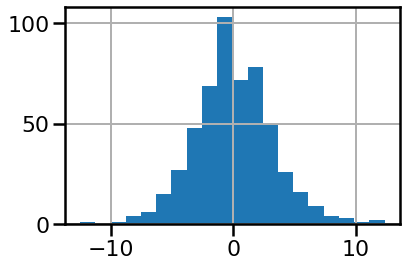

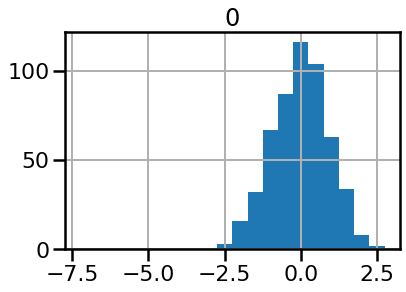

In [45]:
x=pd.DataFrame(predicted_test)
y_test.hist(bins=20)
x.hist(bins=20)

In [48]:
#a dataframe with predictions and true values. useful for plotting
predicted_vs_truth = pd.DataFrame(np.column_stack((predicted_test,y_test )), columns=['predicted', 'truth'])

/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ds806/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


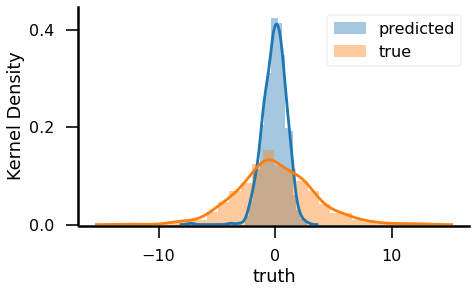

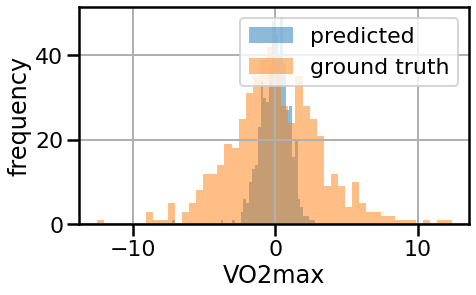

In [49]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(7,4))
    plt.ylabel('Kernel Density')
    sns.despine(offset=1, trim=False)
    sns.distplot(predicted_vs_truth.predicted,label="predicted")
    sns.distplot(predicted_vs_truth.truth,label="true")
    plt.legend()
    
plt.figure(figsize=(7,4))
predicted_vs_truth.predicted.hist(alpha=0.5,bins=50, label='predicted') 
predicted_vs_truth.truth.hist(alpha=0.5,bins=50, label='ground truth') 
plt.ylabel('frequency'); plt.xlabel('VO2max')
#plt.ylim(0,800)
plt.legend(loc='upper right')    